In [1]:
import datetime
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
%matplotlib inline  
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import pickle

Using TensorFlow backend.


# Preprocess

We need to preprocess the keys. 

We need to turn the training data into tensors. 
* train_features, train_labels, 
* test_features, test_labels,
* submission_features

In [2]:
keys = {}
with open('key_1.csv') as f:
    for line in csv.reader(f):
        keys[line[0]] = line[1]

In [3]:
"""
Clip all outliers to 1 std dev

features = array of 490 days before (scaled to 0-1.0)
Labels = next 60 days (0-1.0)
"""
def convert(s):
    if len(s.strip()):
        if float(s) != 0.0:
            return float(s)
        else: 
            return 0.01
    else:
        return 0.01

with open('time_data.pickle', 'wb') as handle:
    time_data = []
    names = []
    with open('train_1.csv') as f:
        reader = csv.reader(f)
        first = True
        s = 0
        for page in reader:
            if not first:
                names.append(page[0])
                time_data.append(np.array(list(map(lambda point: np.array([convert(point)]), page[1:]))))
            first = False
            if s % 1300 ==0:
                print s
            s += 1
    time_data = np.array(time_data)
    pickle.dump(time_data,handle)


0
1300
2600
3900
5200
6500
7800
9100
10400
11700
13000
14300
15600
16900
18200
19500
20800
22100
23400
24700
26000
27300
28600
29900
31200
32500
33800
35100
36400
37700
39000
40300
41600
42900
44200
45500
46800
48100
49400
50700
52000
53300
54600
55900
57200
58500
59800
61100
62400
63700
65000
66300
67600
68900
70200
71500
72800
74100
75400
76700
78000
79300
80600
81900
83200
84500
85800
87100
88400
89700
91000
92300
93600
94900
96200
97500
98800
100100
101400
102700
104000
105300
106600
107900
109200
110500
111800
113100
114400
115700
117000
118300
119600
120900
122200
123500
124800
126100
127400
128700
130000
131300
132600
133900
135200
136500
137800
139100
140400
141700
143000
144300


In [4]:
catagories = {}
index = 0
for name in names:
    cat = name.split('.wikipedia.org')[0].split('_')[-1]
    if cat in catagories:
        catagories[cat].append((name,index))
    else:
        catagories[cat] = [(name,index)]
    index +=1

In [5]:
print catagories.keys()
for cat in catagories:
    print len(catagories[cat])

['ru', 'fr', 'en', 'zh', 'all-agents', 'de', 'spider', 'ja', 'es']
15022
17802
24108
17229
13556
18547
4299
20431
14069


# Normalizing

In [6]:
with open('time_data.pickle', 'rb') as handle:
    time_data = pickle.load(handle)

weights, biases = [], []
new_time_data = []

for page in time_data:
    logged_data = np.log(page)
    mean = np.mean(logged_data[:,0])
    std_dev = np.std(logged_data[:,0])

    biases.append(mean)
    weights.append(std_dev)
    
    result = np.divide(np.add(logged_data,(-mean)), std_dev)
    new_time_data.append(result)

new_time_data = np.array(new_time_data)
print new_time_data.shape

(145063, 550, 1)


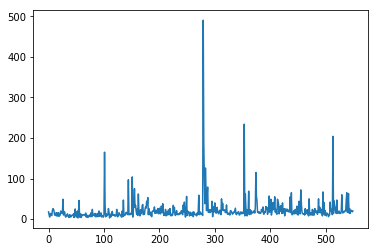

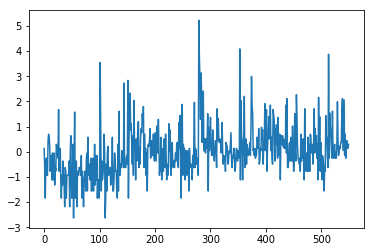

In [7]:
plt.plot(time_data[0])
plt.show()
plt.plot(new_time_data[0])
plt.show()

# Train Test Split

In [13]:
features = []
labels = []

for i in range(len(new_time_data)):
    offset = random.randint(0,70)
    features.append(new_time_data[i,offset:360+offset])
    labels.append(new_time_data[i,360+offset:420+offset,0])
    
features = np.array(features)
labels = np.array(labels)
    
    
x_validation = new_time_data[:,130:490]
y_validation = new_time_data[:,490:,0]

"""
What I need to do is create many different scenarios with lets say 180 days before and 60 days after. 
spaced evenly to allow for it to test many different parts of the year. 

"""

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.10, random_state=42)

# Train Model

In [30]:
from keras import backend as K
def loss(y_true, y_pred):    
    return K.mean(K.abs((K.exp(y_true) - K.exp(y_pred)) / K.exp(y_true)), axis=-1) * 100

In [31]:
model = Sequential()
# model.add(Conv1D(64,kernel_size=16, input_shape=(490,1), use_bias=True))
# model.add(MaxPooling1D((4)))
# model.add(Conv1D(64,kernel_size=8))
# model.add(MaxPooling1D((4)))
# model.add(Conv1D(64,kernel_size=8))
# model.add(Flatten())
# model.add(Dense(60, activation='linear', use_bias=True))

model.add(Conv1D(16,kernel_size=16, input_shape=(360,1), use_bias=True, padding='causal'))
#model.add(MaxPooling1D((8)))
model.add(Conv1D(16,kernel_size=8))
#model.add(MaxPooling1D((2)))
model.add(Conv1D(8,kernel_size=8))
model.add(Flatten())
model.add(Dense(60, activation='linear', use_bias=True))


# Compile model
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 360, 16)           272       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 353, 16)           2064      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 346, 8)            1032      
_________________________________________________________________
flatten_6 (Flatten)          (None, 2768)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 60)                166140    
Total params: 169,508
Trainable params: 169,508
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=3, batch_size=1000)

Train on 130556 samples, validate on 14507 samples
Epoch 1/3
130556/130556 [==============================] - 95s - loss: 718.8683 - acc: 0.0208 - val_loss: 90.7887 - val_acc: 0.0210
Epoch 2/3
130556/130556 [==============================] - 101s - loss: 82.8588 - acc: 0.0231 - val_loss: 87.9657 - val_acc: 0.0261
Epoch 3/3
130556/130556 [==============================] - 97s - loss: 75.8186 - acc: 0.0259 - val_loss: 87.8329 - val_acc: 0.0263


In [33]:
pred = model.predict(x_validation)

# Validation

In [34]:
# https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred_fixed, y_true_fixed = [], time_data[:,490:,0]

for page_id in range(len(pred)):
    result = np.exp(np.add(np.multiply(pred[page_id], weights[page_id]),biases[page_id]))
    y_pred_fixed.append(result)
    
y_pred_fixed = np.array(y_pred_fixed)
print mean_absolute_percentage_error(y_true_fixed, y_pred_fixed)


98.4779986625


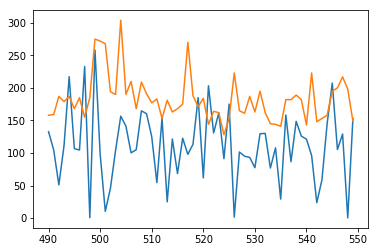

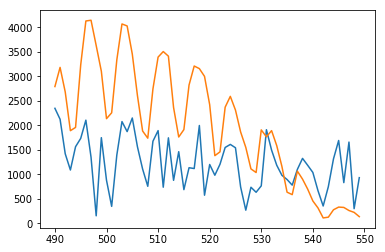

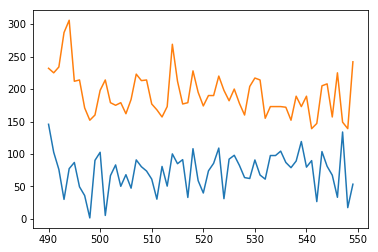

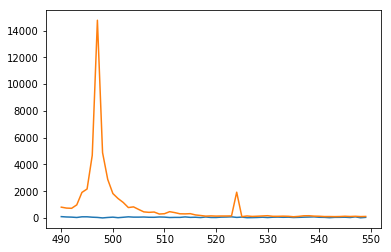

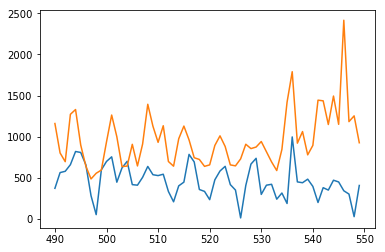

In [39]:
for i in range(5):
    k = random.randint(0,130000)
    plt.plot(range(490,550),y_pred_fixed[k])
    plt.plot(range(490,550),y_true_fixed[k])
    plt.show()

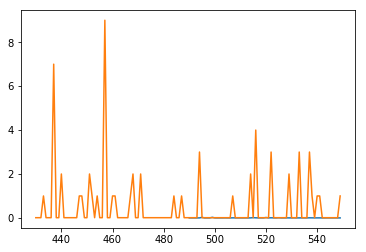

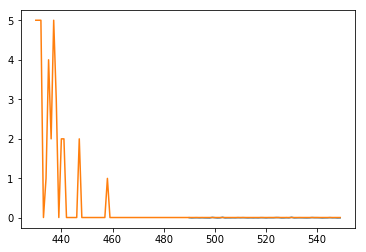

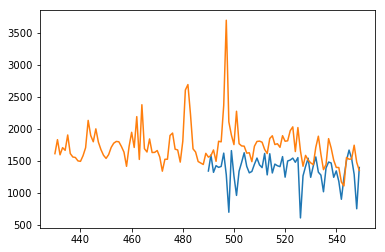

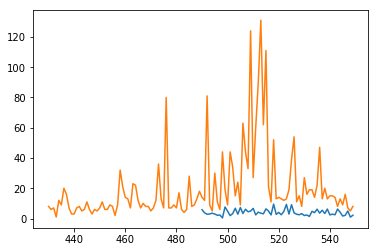

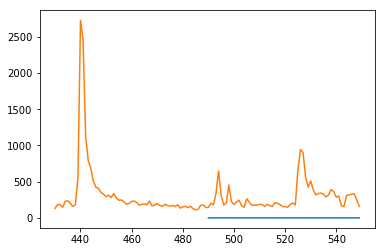

In [38]:
for i in range(5):
    k = random.randint(0,130000)
    plt.plot(range(490,550),y_pred_fixed[k])
    plt.plot(range(430,550),time_data[k][430:])
    plt.show()

# Make Predictions

# Render output

In [ ]:
with open('sub.csv','w+') as o:
    o.write('Id,Visits\n')
    for pred in predictions:
        date = datetime.datetime(2017, 1, 1) + datetime.timedelta(i)
        id = keys["{}_{}".format(page[0], date.strftime('%Y-%m-%d'))]
        o.write('{},{}\n'.format(id, int(pred)))